In [33]:
import json

# Carregar o GeoJSON que contém as geometrias
with open('C:/Users/WORK/Downloads/layerdistrito/LAYER_DISTRITO/DEINFO_DISTRITO2.json', 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

with open('C:/Users/WORK/Downloads/layerdistrito/LAYER_DISTRITO/DEINFO_DISTRITO1.json', 'r', encoding='utf-8') as t:
    attributes_data = json.load(t)




In [25]:
# Vamos supor que 'FEATID' seja o identificador comum entre os dois arquivos
combined_features = []

for feature_geo in geojson_data['features']:
    featid_geo = feature_geo['properties']['FEATID']
    
    # Encontrar o atributo correspondente no segundo arquivo (com base no FEATID)
    for feature_attr in attributes_data['features']:
        featid_attr = feature_attr['properties']['FEATID']
        
        if featid_geo == featid_attr:
            # Combinar as propriedades do arquivo de atributos com a geometria
            feature_geo['properties'].update(feature_attr['properties'])
            combined_features.append(feature_geo)
            break

# Agora criamos um novo GeoJSON combinado com geometrias e atributos
geojson_combined = {
    'type': 'FeatureCollection',
    'features': combined_features
}


KeyError: 'features'

In [40]:
import json

# Carregar os dados de geometrias e atributos
# geojson_data e attributes_data já foram carregados

# Verificar se o número de geometrias e atributos são iguais
if len(geojson_data['geometries']) != len(attributes_data['features']):
    raise ValueError("O número de geometrias e atributos não coincide!")

# Lista para armazenar os recursos combinados
combined_features = []

# Iterar pelos atributos e combinar com as geometrias pelo índice
for i, feature_attr in enumerate(attributes_data['features']):
    # Obter a geometria correspondente (assumimos que a ordem corresponde)
    geometry = geojson_data['geometries'][i]
    
    # Garantir que a geometria seja adicionada corretamente
    feature_attr['geometry'] = geometry
    
    # Adicionar o recurso combinado à lista
    combined_features.append(feature_attr)

# Criar um novo GeoJSON combinado
geojson_combined = {
    'type': 'FeatureCollection',
    'features': combined_features
}

# Agora o geojson_combined contém tanto os atributos quanto as geometrias


In [43]:
import pandas as pd

distritos = []
polygons = []

for feature in geojson_combined['features']:
    distrito = feature['properties']['NOME_DIST']  # Ajuste o nome da propriedade conforme o seu GeoJSON
    geometry = feature['geometry']['coordinates']
    geometry_type = feature['geometry']['type']
    
    # Lidar com Polygon e MultiPolygon
    if geometry_type == 'Polygon':
        polygons.append(geometry)
        distritos.append(distrito)
    elif geometry_type == 'MultiPolygon':
        # Concatenar todos os polígonos
        all_coords = []
        for polygon in geometry:
            all_coords.extend(polygon)
        polygons.append(all_coords)
        distritos.append(distrito)

# Criar um DataFrame com os dados geoespaciais
geo_df = pd.DataFrame({'Distrito': distritos, 'Polygons': polygons})


In [46]:
prob_df = pd.read_csv('C:/Users/WORK/C UNINTER VSCODE/Projetos VSCODE/Previsão do tempo/biteste.csv')

In [47]:
# Calcular as porcentagens
prob_df['Probabilidade_Queda_Pct'] = (prob_df['Probabilidade_Queda'] * 100).round(2).astype(str) + '%'
prob_df['Prob_Class_0_Pct'] = (prob_df['Probabilidade_Classe_0'] * 100).round(2).astype(str) + '%'
prob_df['Prob_Class_1_Pct'] = (prob_df['Probabilidade_Classe_1'] * 100).round(2).astype(str) + '%'
prob_df['Prob_Class_2_Pct'] = (prob_df['Probabilidade_Classe_2'] * 100).round(2).astype(str) + '%'

# Combinar com os dados geoespaciais
df_merged = pd.merge(geo_df, prob_df, on='Distrito', how='left')


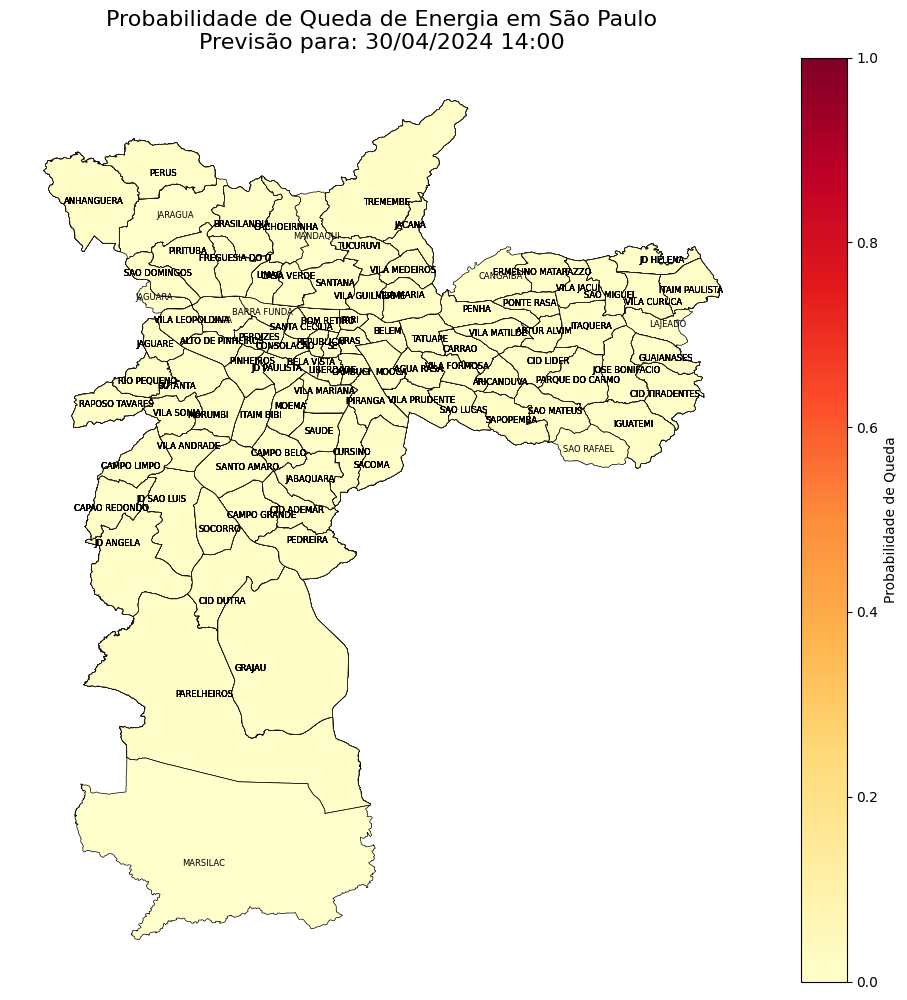

In [57]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
from matplotlib.colors import Normalize



# Calcular as porcentagens, se ainda não tiver sido feito
df_merged['Probabilidade_Queda_Pct'] = (df_merged['Probabilidade_Queda'] * 100).round(2).astype(str) + '%'

# Configurar o plot
fig, ax = plt.subplots(figsize=(12, 12))

patches = []
colors = []

# Definir o colormap e a normalização
cmap = plt.cm.YlOrRd
norm = Normalize(vmin=0, vmax=1)

# Iterar pelos distritos e criar os patches
for idx, row in df_merged.iterrows():
    distrito = row['Distrito']
    polygons = row['Polygons']
    prob_queda = row['Probabilidade_Queda']
    
    # Tratar valores faltantes
    if pd.isnull(prob_queda):
        prob_queda = 0  # Ou outro valor padrão

    for polygon_coords in polygons:
        # Convertendo as coordenadas para um array NumPy
        coords = np.array(polygon_coords)
        
        # Se as coordenadas forem tridimensionais, extrair a parte bidimensional
        if coords.ndim == 3:
            coords = coords[0]
        
        # Certifique-se de que estamos passando as coordenadas corretamente para o Polygon
        poly = Polygon(coords, closed=True)
        patches.append(poly)
        colors.append(prob_queda)

# Criar a coleção de patches
p = PatchCollection(patches, cmap=cmap, norm=norm, edgecolor='black', linewidths=0.5)
p.set_array(np.array(colors))
ax.add_collection(p)

# Adicionar o colorbar
fig.colorbar(p, ax=ax, label='Probabilidade de Queda')

# Ajustar os limites do mapa automaticamente
ax.autoscale_view()

# Remover os eixos
ax.axis('off')

# Obter o horário único dos dados filtrados
horario = df_merged['Data_Hora'].unique()
if len(horario) > 0:
    horario_str = pd.to_datetime(horario[0]).strftime('%d/%m/%Y %H:%M')
else:
    horario_str = 'Horário não disponível'

# Adicionar título
plt.title(f'Probabilidade de Queda de Energia em São Paulo\nPrevisão para: {horario_str}', fontsize=16)

# Adicionar apenas o nome do distrito no mapa
for idx, row in df_merged.iterrows():
    distrito = row['Distrito']
    polygons = row['Polygons']
    
    # Calcular o centroide para posicionar o texto
    for polygon_coords in polygons:
        coords = np.array(polygon_coords)
        if coords.ndim == 3:
            coords = coords[0]
        centroid = coords.mean(axis=0)
        ax.text(centroid[0], centroid[1], f'{distrito}', ha='center', va='center', fontsize=6, color='black')

# Mostrar o gráfico
plt.show()
